In [11]:
import pandas as pd
import numpy as np

In [12]:
players = pd.read_csv('players_22.csv')

c:\Users\edon\Anaconda3\envs\STANDARD\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (25,108) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
features = ['overall', 'potential', 'wage_eur', 'value_eur', 'age']

In [14]:
players = players.dropna(subset=features)

In [15]:
data = players[features].copy()

1. Scale the data
2. Initialize random centroids
3. Label each datapoint
4. Update centroids
5. Repeat 3 & 4 until centroids stop changing

1. Scale the data

Scaling the data so that the min value is 1 and the max value is 10, we don't want a 0 so we add 1

In [16]:
data = ((data - data.min()) / (data.max() - data.min())) * 9 + 1 
data.describe()

,overall,potential,wage_eur,value_eur,age
count,19165.000000,19165.000000,19165.000000,19165.000000,19165.000000
mean,4.670472,5.319998,1.219443,1.131826,4.063345
std,1.346635,1.191076,0.501528,0.353229,1.575838
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.739130,4.521739,1.012876,1.021620,2.666667
50%,4.717391,5.304348,1.064378,1.044817,4.000000
75%,5.500000,6.086957,1.193133,1.092370,5.333333
max,10.000000,10.000000,10.000000,10.000000,10.000000


2. Initialize random centroids

We get random values as centroids using lambda and taking a random number in the dataset for every column. We build a function for that.

In [17]:
def random_centroids(data, k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)

    return pd.concat(centroids, axis=1)

In [8]:
centroids = random_centroids(data, 5)
centroids

3. Label each datapoint

We link every player with the nearest centroid for every column.

In [18]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) **2).sum(axis=1)))

    return distances.idxmin(axis=1)

In [10]:
labels = get_labels(data, centroids)
labels.value_counts()

NameError: name 'centroids' is not defined

4. Update centroids

In [19]:
def new_centroids(data, labels, k):
    return data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [65]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data2d = pca.fit_transform(data)
    centroids2d = pca.fit_transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data2d[:,0], y=data2d[:,1], c=labels)
    plt.scatter(x=centroids2d[:,0], y=centroids2d[:,1], c='blue', label=centroids.columns.values)
    for i, label in enumerate(centroids.columns.values):
        plt.text(centroids2d[i, 0]+0.1, centroids2d[i, 1]+0.1, label)
    plt.show()
    print(centroids)

5. Repeat 3 & 4 step and visualizing

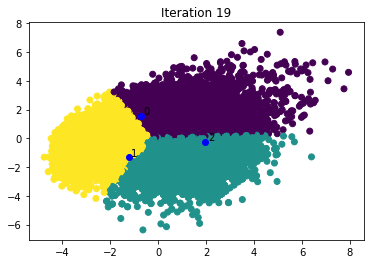

                  0         1         2
overall    5.806043  4.784633  3.206838
potential  6.497993  4.506962  4.928473
wage_eur   1.420001  1.118904  1.028505
value_eur  1.285501  1.044980  1.026614
age        3.596161  5.472247  2.518708


In [66]:
max_iterations = 100
k = 3

centroids = random_centroids(data, k)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, k)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1

In [75]:
players[labels == 0][['short_name'] + features]

,short_name,overall,potential,wage_eur,value_eur,age
0,L. Messi,93,93,320000.0,78000000.0,34
1,R. Lewandowski,92,92,270000.0,119500000.0,32
2,Cristiano Ronaldo,91,91,270000.0,45000000.0,36
3,Neymar Jr,91,91,270000.0,129000000.0,29
4,K. De Bruyne,91,91,350000.0,125500000.0,30
...,...,...,...,...,...,...
13245,D. Scarlett,63,86,3000.0,1500000.0,17
13256,L. Bate,63,83,5000.0,1300000.0,18
13351,Llabrés,63,81,3000.0,1200000.0,19
14144,H. Mejbri,62,84,6000.0,1300000.0,18


Confronting the results with SKLearn results

In [77]:
from sklearn.cluster import KMeans

In [78]:
kmeans = KMeans(3)
kmeans.fit(data)
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids, columns=features).T

,0,1,2
overall,4.801913,3.584879,6.206049
potential,4.502604,5.196108,6.607138
wage_eur,1.113173,1.039224,1.645467
value_eur,1.039956,1.035196,1.406856
age,5.618022,2.709229,4.121045
